In [43]:
import os

import dask.dataframe as dd
import networkit as nk
import networkx as nx
from matplotlib import pyplot as plt
from web3 import Web3

from graph_reinforcement_learning_using_blockchain_data import config

config.load_dotenv()


True

In [44]:
ALCHEMY_API_URL = os.getenv("ALCHEMY_API_URL")
web3 = Web3(Web3.HTTPProvider(ALCHEMY_API_URL))

In [45]:
def parse_logs(s: str):
    safe_globals = {
        "__builtins__": {},
        "AttributeDict": lambda d: d,  # return the dict directly
        "HexBytes": lambda x: x,  # return the string argument
    }
    try:
        return eval(s, safe_globals)
    except Exception as e:
        print("Error parsing logs:", e)
        return []

In [46]:
dd_arbs = dd.read_csv(config.PROCESSED_DATA_DIR / "flashbots" / "Q2_2023" / "arbitrages_with_logs.csv",
                      dtype={'end_amount': 'object',
                             'error': 'object',
                             'profit_amount': 'object',
                             'start_amount': 'object',
                             },
                      converters={'logs': parse_logs}
                      )

In [47]:
dd_arbs["logs"] = dd_arbs["logs"].apply(parse_logs, meta=("logs", "object"))

In [48]:
dd_arbs["label"] = 1

In [49]:
dd_normal = dd.read_csv(config.PROCESSED_DATA_DIR / "flashbots" / "Q2_2023" / "class0_with_logs.csv")
dd_normal["receipt"] = dd_normal["receipt"].apply(parse_logs, meta=("logs", "object"))
dd_normal["logs"] = dd_normal["receipt"].apply(lambda x: x["logs"], meta=("logs", "object"))

In [50]:
dd_normal["label"] = 0

In [51]:
max_block_nr_norm = dd_normal["block_number"].max().compute()

In [52]:
dd_arbs = dd_arbs[dd_arbs["block_number"] <= max_block_nr_norm]

In [53]:
# dd_arbs.head()

In [54]:
# dd_normal.head()

In [55]:
ddf = dd.concat([dd_arbs, dd_normal])

In [56]:
# ddf.head()

In [57]:
def extract_transfer_addresses(log):
    topics = log["topics"]
    ERC20_TRANSFER_SIG = "0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef"
    if topics[0] != ERC20_TRANSFER_SIG:
        return None, None
    if len(topics) < 3:
        return None, None
    from_address = "0x" + topics[1][-40:]
    to_address = "0x" + topics[2][-40:]
    return from_address, to_address


def build_graph_for_block(df_block):
    G = nx.MultiDiGraph()
    address_to_node = {}

    for _, row in df_block.iterrows():
        logs = row["logs"]
        if not logs:
            continue
        for log in logs:
            from_addr, to_addr = extract_transfer_addresses(log)
            if from_addr is None or to_addr is None:
                continue

            if log["data"] == "0x":
                value = 0
            else:
                value = int(log["data"], 16)

            G.add_node(from_addr)
            G.add_node(to_addr)
            G.add_edge(from_addr, to_addr, value=value, log_index=log["logIndex"], tx_hash=log["transactionHash"],
                       topics=log["topics"],
                       transaction_index=log["transactionIndex"], label=row["label"])

    return G, address_to_node


def build_graphs_per_block(df):
    graphs = {}
    for block, group in df.groupby("block_number"):
        G, mapping = build_graph_for_block(group)
        graphs[block] = (G, mapping)
    return graphs

In [58]:
df = ddf.compute()
df = df[df["block_number"] == 16950601]

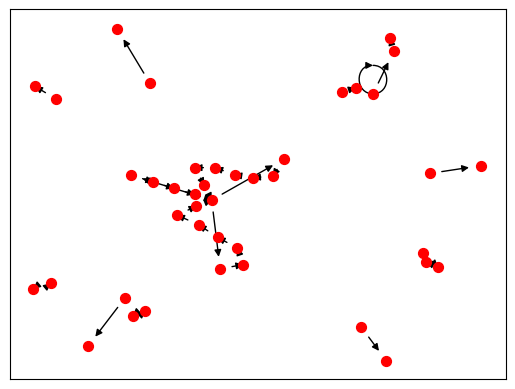

In [59]:
graphs = build_graphs_per_block(df)

block = 16950601
if block in graphs:
    G, mapping = graphs[block]
    plt.figure()
    pos = nx.spring_layout(G, seed=42)
    nx.draw_networkx_nodes(G, pos, node_color="red", node_size=50)
    # nx.draw_networkx_labels(G, pos, font_size=6, font_color="black")

    edge_labels = {}
    for u, v, key, data in G.edges(keys=True, data=True):
        if G.has_edge(v, u):
            rad = 0.2 if key % 2 == 0 else -0.2
        else:
            rad = 0.0
        nx.draw_networkx_edges(
            G, pos,
            edgelist=[(u, v)],
            arrowstyle="-|>",
            arrowsize=10,
            connectionstyle=f"arc3, rad={rad}",
        )
    # plt.margins(0.4)

    plt.show()

In [60]:
nx.write_gml(G, "my_graph.gml")